# Bitcoin Price Forecast with LSTM by Abdou El-Ghazali


## Table of Contents

- Introduction
- Data Collection
- Creating our Timeseries
    - Moving Averages
    - Deltas
- The Model
    - Creating Batches
    - Normalization
    - Creating and Training the Model
- Results
- Analysis

## Introduction

Recurrent Neural Network (RNN) architectures such as Long Short-Term Memory (LSTM) can be useful in time series forecasting. LSTM, when compared to other neural network architectures, improves a model's ability to remember special events that may influence future outcomes. This can be useful for time series with unknown delays between event occurences and their outcomes.

One possible usecase for LSTM is Bitcoin price forecasting. Technical analysis is commonly used for trading and/or investing in Bitcoin. The general notion is that recent price action can be used to forecast the price of Bitcoin in the near future. In greater detail, special chart formations are said to be useful in predicting future price action. This project aims to explore that idea at an abstract level. Using basic technical indicators such as the simple and the exponential moving averages for price, as well as for volume, we hope to see a correlation between Bitcoin's past and near future price action. That is to say, a successful prediction will take the 50 most recent hours of indicator data, and predict the next 1 hour of Bitcoin's price.

Disclaimer: This project is for learning purposes only. This model and any forecasts it may provide should not influence your decision in trading/investing in Bitcoin.

## Data Collection

We will be collecting our market data using [CoinAPI's](https://www.coinapi.io/) free trial. This service allows us to collect periodic market data for various cryptocurrencies. We will use it to collect hourly price, volume, and transaction data for Bitcoin. Our data will be a timeseries beginning in August 2017, and ending in September 2022. It is unknown whether the dates chosen will influence our model's ability to forecast price action. 

In [1]:
import json
import datetime as dt
import numpy as np
import pandas as pd
import requests

In [2]:
with open('secrets.json') as f: # Local secrets file
    secrets = json.load(f)

In [3]:
time_start = dt.datetime(2009, 12, 20, 0, 0).isoformat() # Converting to ISO 8601 format
time_end = dt.datetime(2022, 9, 15, 0, 0).isoformat()

print("Collecting from: " + str(time_start))
print("To: " + str(time_end))

url = "https://rest.coinapi.io/v1/ohlcv/BINANCE_SPOT_BTC_USDT/history?period_id=1HRS&time_start=" + time_start + "&time_end=" + time_end + "&limit=100000"
headers = {"X-CoinAPI-Key" : secrets['coin_api']}

try:
    response = requests.get(url, headers = headers)
    coin_data = json.loads(response.text)
    btc_data = pd.DataFrame(coin_data)
    
except (RuntimeError, TypeError, NameError) as err:
    print(err)
except ValueError:
    print(coin_data)

To: 2022-09-15T00:00:00


In [4]:
# print(btc_data.head())
# print(btc_data.tail())

In [5]:
btc_data_close_indexed = btc_data.set_index(pd.DatetimeIndex(btc_data["time_close"])) # Set close time as index

## Creating Our Timeseries

Our timeseries will consist of various technical analysis-type indicators such as: 
 - price
 - moving averages (simple and exponential)
 - volume
 - trade count 

Though one hour's close value is typically the same as the next hour's open value, it is important to note that we are using the hourly close data provided.
 
We will also engineer a feature called "delta" which takes various indicators and returns their difference. This engineered feature will help our model determine Bitcoin's price equilibrium. Say, for example, the Bitcoin price's 7 hour moving average is far below the 200 hour moving average - this will be apparent in the relevant delta value and may indicate that Bitcoin is oversold; a condition that is said to create "bullish sentiment". In general, all of our model's delta features will be at equilibrium at 0 value. We will create deltas for Bitcoin's price, moving averages, as well as trade volume.

### Moving Averages

In [6]:
def movingAverage(a, window_size): # Input: series, int
    return a.rolling(window_size).mean()

def exponentialMovingAverage(a, window_size): # Input: series, int
    return round(a.ewm(span=window_size, min_periods=window_size, adjust=False).mean(), 2)

# Create a series of moving averages
btc_data_close_indexed["ma_7"] = movingAverage(btc_data_close_indexed["price_close"], 7)
btc_data_close_indexed["ma_50"] = movingAverage(btc_data_close_indexed["price_close"], 50)
btc_data_close_indexed["ma_200"] = movingAverage(btc_data_close_indexed["price_close"], 200)
btc_data_close_indexed["ema_7"] = exponentialMovingAverage(btc_data_close_indexed["price_close"], 7)
btc_data_close_indexed["ema_50"] = exponentialMovingAverage(btc_data_close_indexed["price_close"], 50)
btc_data_close_indexed["ema_200"] = exponentialMovingAverage(btc_data_close_indexed["price_close"], 200)
btc_data_close_indexed["vol_7"] = exponentialMovingAverage(btc_data_close_indexed["volume_traded"], 7)
btc_data_close_indexed["vol_50"] = exponentialMovingAverage(btc_data_close_indexed["volume_traded"], 50)
btc_data_close_indexed["vol_200"] = exponentialMovingAverage(btc_data_close_indexed["volume_traded"], 200)

# print(btc_data_close_indexed.head()) # First entries will always be Nan for a moving average
# print(btc_data_close_indexed.tail())

### Deltas

In [7]:
# Creating a series of price deltas
df = btc_data_close_indexed[["price_close", "volume_traded", "trades_count", 
                             "ma_7", "ma_50", "ma_200", 
                             "ema_7", "ema_50", "ema_200",
                             "vol_7", "vol_50", "vol_200"]].dropna() # Dropping empty entries (byproduct of moving averages)

df["delta_7"] = df["price_close"] - df["ema_7"] # Price difference between the close and the 7 EMA
df["delta_50"] = df["price_close"] - df["ema_50"]
df["delta_200"] = df["price_close"] - df["ema_200"]

df["delta_7_50"] = df["ema_7"] - df["ema_50"] # Price difference between the 7 and 50 EMA
df["delta_7_200"] = df["ema_7"] - df["ema_200"]
df["delta_50_200"] = df["ema_50"] - df["ema_200"]

# print(df.head())

In [8]:
df.to_csv("btc_data.csv") # Saving our timeseries

## The Model

Our data is almost ready. First, we need to split our data into batches. In other words, we must create a timeseries consisting of many batches of 50 timesteps as input and 1 timestep as an output. Here, we can make choices as to how the batches are collected. For example, if a timestep is used in one batch, should it be reused in another? For more detail, check out [sequence length and sequence stride](https://www.tensorflow.org/api_docs/python/tf/keras/utils/timeseries_dataset_from_array). For our model, we chose to include each timestep in about two batches. That is to say, we set the sequence stride to be half of the sample length.
- Sample length/Batch size = 50 hours
- Sequence length = 50 hours
- Sequence stride = 25 hours

Next, we need to normalize our data so that the model can comprehend it more easily. For this step, we simply use sklearn's preprocessing tools ([MinMaxScaler](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html)). In order to make sense of our data later on, we must keep track of the scaler values used.

In [9]:
import numpy as np
import pandas as pd
import tensorflow as tf

from sklearn.model_selection import train_test_split

df = pd.read_csv("btc_data.csv", parse_dates=True, index_col=0)
data = df.dropna().to_numpy().astype(int)

# print(np.shape(data))

### Creating Batches

In [10]:
sample_length = 50 # Given the last 50 timeperiods, predict the next timeperiod
batch_size = np.floor(len(data)/sample_length)

input_data = data[:-(sample_length)]
targets = data[sample_length:]
dataset = tf.keras.preprocessing.timeseries_dataset_from_array(input_data, 
                                                               targets, 
                                                               sequence_length=sample_length,
                                                               sequence_stride=sample_length/2,
                                                               batch_size=len(data)
                                                              )

for batch in dataset:
    x, y = batch
    assert np.array_equal(x[0], data[:sample_length])  # First sequence: steps [0-9]
    assert np.array_equal(y[0], data[sample_length])  # Corresponding target: step 10
    break

In [11]:
x = x
y = y[:,:1]
print(np.shape(x))
print(np.shape(y))

(1763, 50, 18)
(1763, 1)


### Normalization

In [12]:
# data normalization with sklearn
from sklearn.preprocessing import MinMaxScaler, RobustScaler

def descale(a, scaler_values):
    transpose = np.copy(a).T
    
    if len(a.shape) == 3:
        for i, row in enumerate(transpose):
            transpose[i] = scaler_values[i].inverse_transform(row)
    elif len(a.shape) == 2:
        transpose = scaler_values.inverse_transform(transpose) # fit scaler on training data
    else:
        print("Descale Shape Error.")
        print(len(a.shape))
        
    return np.asarray(transpose.T, dtype=int)

def scaleValues(array, scaler_values):
    def scale(a, scaler_values):
        transpose = np.copy(a).T
        if len(a.shape) == 3:
            for i, row in enumerate(transpose):
                scaler_values[i] = MinMaxScaler().fit(row) # fit scaler on training data
                transpose[i] = scaler_values[i].transform(row)
        elif len(a.shape) == 2:
            scaler_values = scaler_values[0]
            transpose = scaler_values.transform(transpose) # fit scaler on training data
        else:
            print("Scale Shape Error.")
            print(len(a.shape))
            
        return np.asarray(transpose.T), scaler_values
    
    scaled, scaler_values = scale(array, scaler_values)
    descaled = descale(scaled, scaler_values)
    
    return scaled, descaled, scaler_values


scaled_x, descaled_x, scaler_values_x = scaleValues(np.asarray(x), {})
scaled_y, descaled_y, scaler_values_y = scaleValues(np.asarray(y), scaler_values_x)

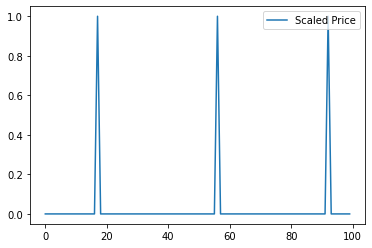

In [13]:
import matplotlib.pyplot as plt

plt.plot(list(range(100)), scaled_x[:100,:1,0].reshape(100,1), label='Scaled Price')

plt.legend(loc='upper right')
plt.show()

### Creating and Training the Model

In [14]:
# This splits our data into train and test sets without shuffling them
train_data, test_data, train_labels, test_labels = train_test_split(scaled_x, scaled_y, test_size=0.2, shuffle=False)
_, _, descaled_train_labels, descaled_test_labels = train_test_split(descaled_x, descaled_y, test_size=0.2, shuffle=False)

In [15]:
from tensorflow.keras.layers import BatchNormalization, LayerNormalization, LSTM, Bidirectional, Dense, \
                                    Flatten, Dropout, Input, TimeDistributed, GRU
opt = tf.keras.optimizers.Adam(learning_rate=0.001)
model = tf.keras.Sequential()

# Input shape
model.add(Input(shape=(sample_length, 18))) # 18 features being used

# Dropout to Prevent overfitting
model.add(Dropout(0.5)) 

# LSTM and Dense layers
model.add(BatchNormalization(axis=2))
model.add(Bidirectional(LSTM(18, return_sequences=True)))
model.add(Bidirectional(LSTM(18)))
model.add(Dense(36, activation="elu"))
model.add(Dense(18, activation="elu"))

# Output Layer
model.add(Dense(1))

model.summary()
model.compile(optimizer=opt, loss="mean_squared_error", metrics=["mean_squared_error"])

fitModel = model.fit( train_data
                    , train_labels
                    , epochs=1000
                    , batch_size=1000
                    , shuffle=True
                    , validation_split=0.3
                    , verbose=1 
                    )

results = model.evaluate(test_data, test_labels)

print(results)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dropout (Dropout)            (None, 50, 18)            0         
_________________________________________________________________
batch_normalization (BatchNo (None, 50, 18)            72        
_________________________________________________________________
bidirectional (Bidirectional (None, 50, 36)            5328      
_________________________________________________________________
bidirectional_1 (Bidirection (None, 36)                7920      
_________________________________________________________________
dense (Dense)                (None, 36)                1332      
_________________________________________________________________
dense_1 (Dense)              (None, 18)                666       
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 1

Epoch 44/1000
1/1 [==============================] - 0s 56ms/step - loss: 0.0752 - mean_squared_error: 0.0752 - val_loss: 0.1327 - val_mean_squared_error: 0.1327
Epoch 45/1000
1/1 [==============================] - 0s 57ms/step - loss: 0.0719 - mean_squared_error: 0.0719 - val_loss: 0.1297 - val_mean_squared_error: 0.1297
Epoch 46/1000
1/1 [==============================] - 0s 59ms/step - loss: 0.0754 - mean_squared_error: 0.0754 - val_loss: 0.1264 - val_mean_squared_error: 0.1264
Epoch 47/1000
1/1 [==============================] - 0s 58ms/step - loss: 0.0743 - mean_squared_error: 0.0743 - val_loss: 0.1230 - val_mean_squared_error: 0.1230
Epoch 48/1000
1/1 [==============================] - 0s 56ms/step - loss: 0.0699 - mean_squared_error: 0.0699 - val_loss: 0.1199 - val_mean_squared_error: 0.1199
Epoch 49/1000
1/1 [==============================] - 0s 50ms/step - loss: 0.0741 - mean_squared_error: 0.0741 - val_loss: 0.1170 - val_mean_squared_error: 0.1170
Epoch 50/1000
1/1 [=========

1/1 [==============================] - 0s 53ms/step - loss: 0.0564 - mean_squared_error: 0.0564 - val_loss: 0.0609 - val_mean_squared_error: 0.0609
Epoch 145/1000
1/1 [==============================] - 0s 54ms/step - loss: 0.0555 - mean_squared_error: 0.0555 - val_loss: 0.0605 - val_mean_squared_error: 0.0605
Epoch 146/1000
1/1 [==============================] - 0s 54ms/step - loss: 0.0551 - mean_squared_error: 0.0551 - val_loss: 0.0600 - val_mean_squared_error: 0.0600
Epoch 147/1000
1/1 [==============================] - 0s 56ms/step - loss: 0.0582 - mean_squared_error: 0.0582 - val_loss: 0.0597 - val_mean_squared_error: 0.0597
Epoch 148/1000
1/1 [==============================] - 0s 52ms/step - loss: 0.0593 - mean_squared_error: 0.0593 - val_loss: 0.0595 - val_mean_squared_error: 0.0595
Epoch 149/1000
1/1 [==============================] - 0s 51ms/step - loss: 0.0559 - mean_squared_error: 0.0559 - val_loss: 0.0594 - val_mean_squared_error: 0.0594
Epoch 150/1000
1/1 [=================

1/1 [==============================] - 0s 51ms/step - loss: 0.0519 - mean_squared_error: 0.0519 - val_loss: 0.0425 - val_mean_squared_error: 0.0425
Epoch 245/1000
1/1 [==============================] - 0s 53ms/step - loss: 0.0471 - mean_squared_error: 0.0471 - val_loss: 0.0424 - val_mean_squared_error: 0.0424
Epoch 246/1000
1/1 [==============================] - 0s 52ms/step - loss: 0.0494 - mean_squared_error: 0.0494 - val_loss: 0.0422 - val_mean_squared_error: 0.0422
Epoch 247/1000
1/1 [==============================] - 0s 51ms/step - loss: 0.0511 - mean_squared_error: 0.0511 - val_loss: 0.0426 - val_mean_squared_error: 0.0426
Epoch 248/1000
1/1 [==============================] - 0s 57ms/step - loss: 0.0524 - mean_squared_error: 0.0524 - val_loss: 0.0434 - val_mean_squared_error: 0.0434
Epoch 249/1000
1/1 [==============================] - 0s 56ms/step - loss: 0.0515 - mean_squared_error: 0.0515 - val_loss: 0.0438 - val_mean_squared_error: 0.0438
Epoch 250/1000
1/1 [=================

1/1 [==============================] - 0s 57ms/step - loss: 0.0460 - mean_squared_error: 0.0460 - val_loss: 0.0358 - val_mean_squared_error: 0.0358
Epoch 345/1000
1/1 [==============================] - 0s 59ms/step - loss: 0.0481 - mean_squared_error: 0.0481 - val_loss: 0.0357 - val_mean_squared_error: 0.0357
Epoch 346/1000
1/1 [==============================] - 0s 55ms/step - loss: 0.0467 - mean_squared_error: 0.0467 - val_loss: 0.0359 - val_mean_squared_error: 0.0359
Epoch 347/1000
1/1 [==============================] - 0s 55ms/step - loss: 0.0450 - mean_squared_error: 0.0450 - val_loss: 0.0366 - val_mean_squared_error: 0.0366
Epoch 348/1000
1/1 [==============================] - 0s 54ms/step - loss: 0.0453 - mean_squared_error: 0.0453 - val_loss: 0.0369 - val_mean_squared_error: 0.0369
Epoch 349/1000
1/1 [==============================] - 0s 57ms/step - loss: 0.0429 - mean_squared_error: 0.0429 - val_loss: 0.0366 - val_mean_squared_error: 0.0366
Epoch 350/1000
1/1 [=================

1/1 [==============================] - 0s 57ms/step - loss: 0.0428 - mean_squared_error: 0.0428 - val_loss: 0.0357 - val_mean_squared_error: 0.0357
Epoch 445/1000
1/1 [==============================] - 0s 54ms/step - loss: 0.0436 - mean_squared_error: 0.0436 - val_loss: 0.0362 - val_mean_squared_error: 0.0362
Epoch 446/1000
1/1 [==============================] - 0s 54ms/step - loss: 0.0405 - mean_squared_error: 0.0405 - val_loss: 0.0382 - val_mean_squared_error: 0.0382
Epoch 447/1000
1/1 [==============================] - 0s 54ms/step - loss: 0.0437 - mean_squared_error: 0.0437 - val_loss: 0.0386 - val_mean_squared_error: 0.0386
Epoch 448/1000
1/1 [==============================] - 0s 55ms/step - loss: 0.0447 - mean_squared_error: 0.0447 - val_loss: 0.0367 - val_mean_squared_error: 0.0367
Epoch 449/1000
1/1 [==============================] - 0s 57ms/step - loss: 0.0447 - mean_squared_error: 0.0447 - val_loss: 0.0358 - val_mean_squared_error: 0.0358
Epoch 450/1000
1/1 [=================

1/1 [==============================] - 0s 52ms/step - loss: 0.0380 - mean_squared_error: 0.0380 - val_loss: 0.0376 - val_mean_squared_error: 0.0376
Epoch 545/1000
1/1 [==============================] - 0s 56ms/step - loss: 0.0408 - mean_squared_error: 0.0408 - val_loss: 0.0386 - val_mean_squared_error: 0.0386
Epoch 546/1000
1/1 [==============================] - 0s 53ms/step - loss: 0.0439 - mean_squared_error: 0.0439 - val_loss: 0.0378 - val_mean_squared_error: 0.0378
Epoch 547/1000
1/1 [==============================] - 0s 55ms/step - loss: 0.0413 - mean_squared_error: 0.0413 - val_loss: 0.0373 - val_mean_squared_error: 0.0373
Epoch 548/1000
1/1 [==============================] - 0s 54ms/step - loss: 0.0392 - mean_squared_error: 0.0392 - val_loss: 0.0373 - val_mean_squared_error: 0.0373
Epoch 549/1000
1/1 [==============================] - 0s 55ms/step - loss: 0.0417 - mean_squared_error: 0.0417 - val_loss: 0.0369 - val_mean_squared_error: 0.0369
Epoch 550/1000
1/1 [=================

1/1 [==============================] - 0s 54ms/step - loss: 0.0382 - mean_squared_error: 0.0382 - val_loss: 0.0378 - val_mean_squared_error: 0.0378
Epoch 645/1000
1/1 [==============================] - 0s 53ms/step - loss: 0.0374 - mean_squared_error: 0.0374 - val_loss: 0.0366 - val_mean_squared_error: 0.0366
Epoch 646/1000
1/1 [==============================] - 0s 52ms/step - loss: 0.0361 - mean_squared_error: 0.0361 - val_loss: 0.0367 - val_mean_squared_error: 0.0367
Epoch 647/1000
1/1 [==============================] - 0s 50ms/step - loss: 0.0418 - mean_squared_error: 0.0418 - val_loss: 0.0373 - val_mean_squared_error: 0.0373
Epoch 648/1000
1/1 [==============================] - 0s 53ms/step - loss: 0.0394 - mean_squared_error: 0.0394 - val_loss: 0.0386 - val_mean_squared_error: 0.0386
Epoch 649/1000
1/1 [==============================] - 0s 54ms/step - loss: 0.0402 - mean_squared_error: 0.0402 - val_loss: 0.0381 - val_mean_squared_error: 0.0381
Epoch 650/1000
1/1 [=================

1/1 [==============================] - 0s 55ms/step - loss: 0.0343 - mean_squared_error: 0.0343 - val_loss: 0.0372 - val_mean_squared_error: 0.0372
Epoch 745/1000
1/1 [==============================] - 0s 56ms/step - loss: 0.0349 - mean_squared_error: 0.0349 - val_loss: 0.0382 - val_mean_squared_error: 0.0382
Epoch 746/1000
1/1 [==============================] - 0s 54ms/step - loss: 0.0367 - mean_squared_error: 0.0367 - val_loss: 0.0382 - val_mean_squared_error: 0.0382
Epoch 747/1000
1/1 [==============================] - 0s 54ms/step - loss: 0.0375 - mean_squared_error: 0.0375 - val_loss: 0.0378 - val_mean_squared_error: 0.0378
Epoch 748/1000
1/1 [==============================] - 0s 53ms/step - loss: 0.0361 - mean_squared_error: 0.0361 - val_loss: 0.0381 - val_mean_squared_error: 0.0381
Epoch 749/1000
1/1 [==============================] - 0s 53ms/step - loss: 0.0358 - mean_squared_error: 0.0358 - val_loss: 0.0391 - val_mean_squared_error: 0.0391
Epoch 750/1000
1/1 [=================

1/1 [==============================] - 0s 52ms/step - loss: 0.0355 - mean_squared_error: 0.0355 - val_loss: 0.0377 - val_mean_squared_error: 0.0377
Epoch 845/1000
1/1 [==============================] - 0s 52ms/step - loss: 0.0321 - mean_squared_error: 0.0321 - val_loss: 0.0382 - val_mean_squared_error: 0.0382
Epoch 846/1000
1/1 [==============================] - 0s 51ms/step - loss: 0.0366 - mean_squared_error: 0.0366 - val_loss: 0.0375 - val_mean_squared_error: 0.0375
Epoch 847/1000
1/1 [==============================] - 0s 54ms/step - loss: 0.0344 - mean_squared_error: 0.0344 - val_loss: 0.0371 - val_mean_squared_error: 0.0371
Epoch 848/1000
1/1 [==============================] - 0s 51ms/step - loss: 0.0385 - mean_squared_error: 0.0385 - val_loss: 0.0373 - val_mean_squared_error: 0.0373
Epoch 849/1000
1/1 [==============================] - 0s 52ms/step - loss: 0.0361 - mean_squared_error: 0.0361 - val_loss: 0.0377 - val_mean_squared_error: 0.0377
Epoch 850/1000
1/1 [=================

1/1 [==============================] - 0s 53ms/step - loss: 0.0351 - mean_squared_error: 0.0351 - val_loss: 0.0386 - val_mean_squared_error: 0.0386
Epoch 945/1000
1/1 [==============================] - 0s 49ms/step - loss: 0.0322 - mean_squared_error: 0.0322 - val_loss: 0.0388 - val_mean_squared_error: 0.0388
Epoch 946/1000
1/1 [==============================] - 0s 54ms/step - loss: 0.0347 - mean_squared_error: 0.0347 - val_loss: 0.0399 - val_mean_squared_error: 0.0399
Epoch 947/1000
1/1 [==============================] - 0s 52ms/step - loss: 0.0333 - mean_squared_error: 0.0333 - val_loss: 0.0409 - val_mean_squared_error: 0.0409
Epoch 948/1000
1/1 [==============================] - 0s 55ms/step - loss: 0.0354 - mean_squared_error: 0.0354 - val_loss: 0.0400 - val_mean_squared_error: 0.0400
Epoch 949/1000
1/1 [==============================] - 0s 50ms/step - loss: 0.0345 - mean_squared_error: 0.0345 - val_loss: 0.0384 - val_mean_squared_error: 0.0384
Epoch 950/1000
1/1 [=================

## Results

The model seems to converge. Let's see how it holds up against our test dataset.

In [16]:
n = 0
prediction = model.predict(test_data)

print("Prediction: " + str(prediction[n]))
print("Actual: " + str(test_labels[n]))

Prediction: [-0.04384753]
Actual: [0.13073171]


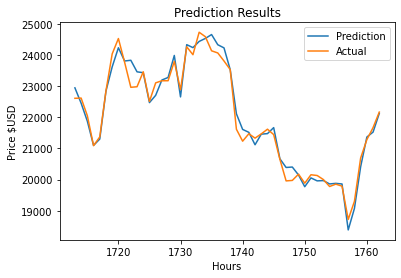

In [18]:
import matplotlib.pyplot as plt

# It's important to remember to descale our data after prediction in order to make sense of the results 
temp = np.concatenate((train_labels, prediction))
temp = descale(temp, scaler_values_y)

plt.plot(list(range(len(y)))[-50:], temp[-50:], label='Prediction')
plt.plot(list(range(len(y)))[-50:], y[-50:], label='Actual')

plt.legend(loc='upper right')
plt.title('Prediction Results')
plt.ylabel('Price $USD')
plt.xlabel('Hours')
plt.show()

## Analysis

It's difficult to come to any conclusion purely based off the graph produced. Remember, we're taking 50 hours of Bitcoin price data and predicting the next 1 hour only. In other words, every datapoint in our Prediction Results graph is a prediction made with 50 hours of price history context; this is why predictions and actual price data match so closely. What we really need to study in order to understand our model's success, is whether the model's sentiment (bullish or bearish) matched the actual price action.

In order to do this, we will grade our model based off of good and bad predictions:
- Good:
    - The model **predicts positive** price movement, actual price movement is **also positive**
    - The model **predicts negative** price movement, actual price movement is **also negative**
    - The model **predicts neutral** price movement, actual price movement is **also neutral**
- Bad:
    - The model **predicts positive** price movement, actual price movement is **not positive**
    - The model **predicts negative** price movement, actual price movement is **not negative**
    - The model **predicts neutral** price movement, actual price movement is **not neutral**
    
Our model's accuracy will be determined by the rate of good predictions against total predictions.

In [19]:
# The model is predicting the next timestep given previous timesteps,
# so we need to analyze how accurate it is based on each timestep predicted
print("Predictions: ")
print(temp[-2:])
print("Actual: ")
print(y[-2:])

Predictions: 
[[21525]
 [22125]]
Actual: 
tf.Tensor(
[[21670]
 [22167]], shape=(2, 1), dtype=int32)


In [20]:
# If the next timestep gives us a higher price, we will label it 1 (positive)
# If the next timestep gives us a lower price, we will label it -1 (negative)
# Otherwise 0 (neutral)

predictions = temp[-len(prediction):]
actual = y[-len(prediction):]

prediction_analysis = []
for i, timestep in enumerate(predictions):
    try:
        if predictions[i+1] > predictions[i]:
            prediction_analysis.append(1)
        elif predictions[i+1] < predictions[i]:
            prediction_analysis.append(-1)
        else:
            print("Zero.")
            prediction_analysis.append(0)
    except:
        print("Out of data.")
        
actual_analysis = []
for i, timestep in enumerate(actual):
    try:
        if actual[i+1] > actual[i]:
            actual_analysis.append(1)
        elif actual[i+1] < actual[i]:
            actual_analysis.append(-1)
        else:
            print("Zero.")
            actual_analysis.append(0)
    except:
        print("Out of data.")

Out of data.
Out of data.


In [21]:
good = 0
bad = 0
for i in range(len(prediction_analysis)):
    if actual_analysis[i] == prediction_analysis[i]:
        good += 1
    else:
        bad += 1
print("Good predictions: " + str(good))
print("Bad predictions: " + str(bad))
print("Accuracy: " + str(good/(good+bad)*100) + "%")

Good predictions: 290
Bad predictions: 62
Accuracy: 82.38636363636364%


In [22]:
model.save('BTCPriceModel')

INFO:tensorflow:Assets written to: BTCPriceModel\assets


INFO:tensorflow:Assets written to: BTCPriceModel\assets
